### Carotid data


In [1]:
import scipy.io

# Load the .mat files
psf_data = scipy.io.loadmat("exp/datasets/carotidNew/caro_psf.mat")
rf_data = scipy.io.loadmat("exp/datasets/carotidNew/rf.mat")
bmode_data = scipy.io.loadmat("exp/datasets/carotidNew/bmode.mat")

# Extract the arrays (assuming the key is not '__header__', etc.)
psf_keys = [k for k in psf_data.keys() if not k.startswith("__")]
rf_keys = [k for k in rf_data.keys() if not k.startswith("__")]
bmode_keys = [k for k in bmode_data.keys() if not k.startswith("__")]

# Get the shapes of the relevant arrays
psf_shape = psf_data[psf_keys[0]].shape
rf_shape = rf_data[rf_keys[0]].shape
bmode_shape = bmode_data[bmode_keys[0]].shape

psf_shape, rf_shape, bmode_shape


((15, 11), (4480, 384), (4480, 384))

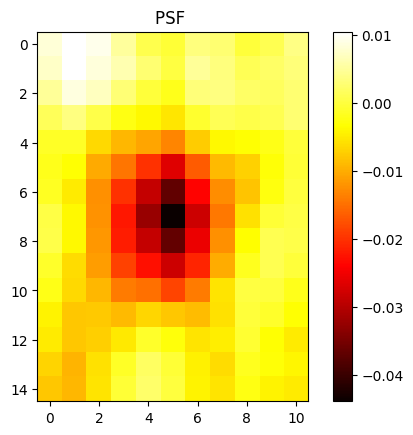

In [2]:
import matplotlib.pyplot as plt
plt.imshow(psf_data[psf_keys[0]], cmap='hot')
plt.title("PSF ")
plt.colorbar()
plt.show()


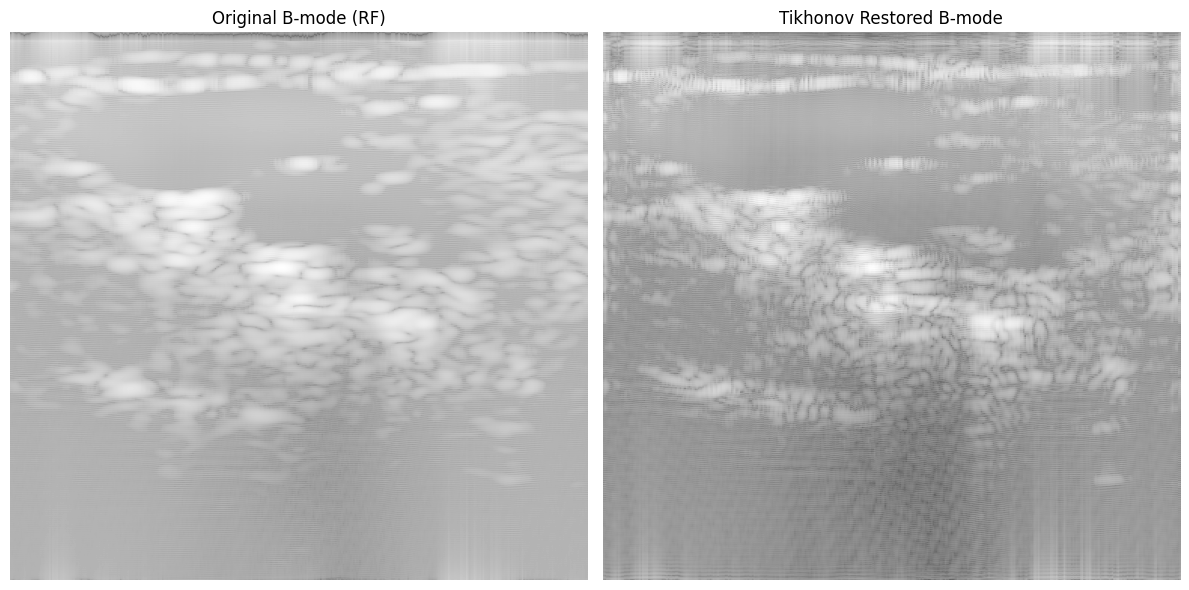

In [26]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# === Load files ===
rf = scipy.io.loadmat('exp/datasets/carotidNew/rf.mat')['rf']
psf_crop = scipy.io.loadmat('exp/datasets/carotidNew/psf_crop.mat')['psf']

# === Normalize and construct degradation matrix ===
H = psf_crop / np.sum(np.abs(psf_crop))
Mh, Nh = H.shape
rf_H, rf_W = rf.shape
center = [Mh // 2, Nh // 2]
padded_H = np.pad(H, ((0, rf_H - Mh), (0, rf_W - Nh)), mode='constant')
shifted_H = np.roll(np.roll(padded_H, -center[0] + 1, axis=0), -center[1] + 1, axis=1)
D = np.fft.fft2(shifted_H)

# === Apply Tikhonov Filtering ===
rfn = rf / np.max(np.abs(rf))
SNR = 1000
VivoTK = np.fft.ifft2(np.fft.fft2(rfn) * np.conj(D) / (1/SNR + np.conj(D)*D)).real

# === Convert to B-mode ===
def to_bmode(data, eps=1e-6):
    bmode = 20 * np.log10(np.abs(hilbert(data, axis=0)) + eps)
    bmode -= bmode.min()
    return 255 * bmode / bmode.max()

bmode_rf = to_bmode(rf)
bmode_tikhonov = to_bmode(VivoTK)

# === Plot ===
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(bmode_rf , cmap='gray', aspect='auto')
plt.title("Original B-mode (RF)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bmode_tikhonov , cmap='gray', aspect='auto')
plt.title("Tikhonov Restored B-mode")
plt.axis('off')

plt.tight_layout()
plt.show()


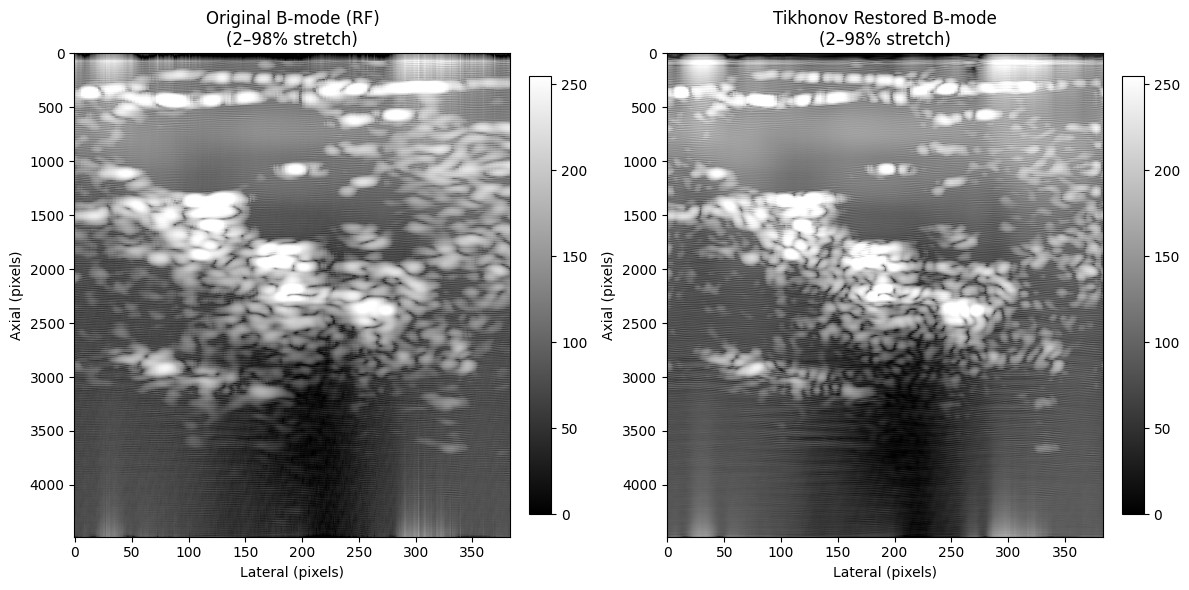

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import scipy.io

# --- Reconstruct bmode_vivo and bmode_tikhonov as before ---
rf = scipy.io.loadmat('exp/datasets/carotidNew/rf.mat')['rf']
psf_crop = scipy.io.loadmat('exp/datasets/carotidNew/psf_crop.mat')['psf_crop']

# build D, compute VivoTK, then:

def to_bmode_raw(data, eps=1e-6):
    env = np.abs(hilbert(data, axis=0))
    log_env = 20 * np.log10(env + eps)
    return log_env  # do NOT normalize here—keep original dynamic range

bmode_vivo_raw      = to_bmode_raw(rf)
bmode_tikhonov_raw  = to_bmode_raw(VivoTK)

# --- Percentile clipping function ---
def stretch_percentiles(image, low_pct=2, high_pct=98):
    """
    Clip image at low_pct and high_pct percentiles, then stretch to [0, 255].
    """
    plow, phigh = np.percentile(image, (low_pct, high_pct))
    img_clipped = np.clip(image, plow, phigh)
    img_clipped -= plow
    img_clipped = 255 * (img_clipped / (phigh - plow + 1e-12))
    return img_clipped

# Apply 2–98 percentile stretch
bmode_vivo_disp      = stretch_percentiles(bmode_vivo_raw, 2, 98)
bmode_tikhonov_disp  = stretch_percentiles(bmode_tikhonov_raw, 2, 98)

# --- Plot with better contrast ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

im1 = axs[0].imshow(bmode_vivo_disp, cmap='gray', aspect='auto')
axs[0].set_title("Original B-mode (RF)\n(2–98% stretch)")
axs[0].set_xlabel("Lateral (pixels)")
axs[0].set_ylabel("Axial (pixels)")
plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

im2 = axs[1].imshow(bmode_tikhonov_disp, cmap='gray', aspect='auto')
axs[1].set_title("Tikhonov Restored B-mode\n(2–98% stretch)")
axs[1].set_xlabel("Lateral (pixels)")
axs[1].set_ylabel("Axial (pixels)")
plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [31]:
rf.shape

(4480, 384)

In [32]:
VivoTK.shape

(4480, 384)

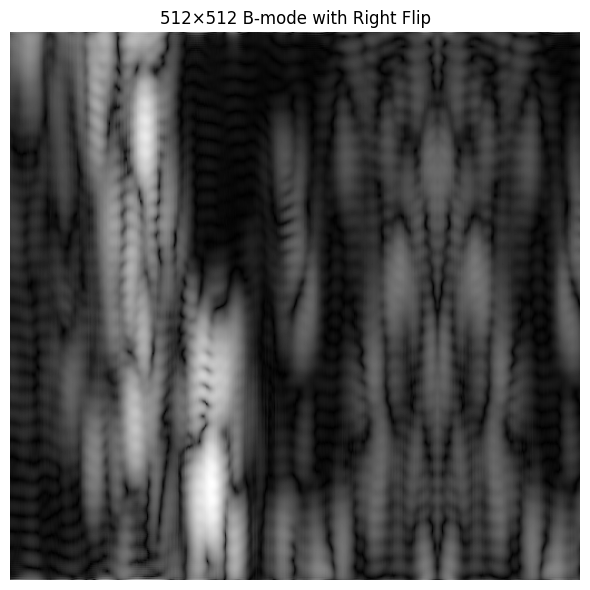

In [41]:
import numpy as np
import scipy.io
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Load the RF data
carotid_data = scipy.io.loadmat('exp/datasets/carotidNew/rf.mat')
rf_data = carotid_data['rf']

# Crop a 512×W section from depth 1000
rf_section = rf_data[1500:1500+512, :]  # shape (512, W)
H, W = rf_section.shape

# Step 1: Copy original into new 512×512 matrix
rf_filled = np.zeros((512, 512), dtype=rf_section.dtype)
rf_filled[:, :W] = rf_section

# Step 2: Fill remaining with flipped rightmost part
fill_width = 512 - W
rf_filled[:, W:] = np.fliplr(rf_section[:, -fill_width:])

# Step 3: Hilbert transform + log compression
LogB = 500
env = np.abs(hilbert(rf_filled, axis=0))
log_env = np.log(env + LogB)

# Plot the final 512×512 result
plt.figure(figsize=(6, 6))
plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('512×512 B-mode with Right Flip')
plt.axis('off')
plt.tight_layout()
plt.show()


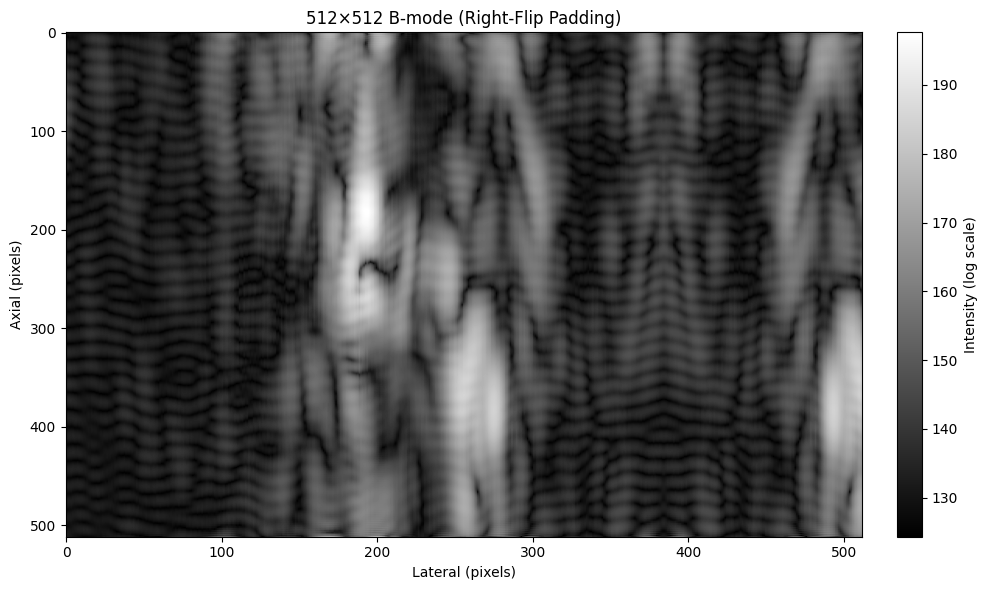

In [47]:
import numpy as np
import scipy.io
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# --- (Your existing steps to build rf_filled and log_env) ---
carotid_data = scipy.io.loadmat('exp/datasets/carotidNew/rf.mat')
rf_data = carotid_data['rf']

# Crop a 512×W section from depth 2000
rf_section = rf_data[2000:2000+512, :]   # shape = (512, W)
H, W = rf_section.shape                  # H=512, W=384 (for example)

# Step 1: Copy original into new 512×512 matrix
rf_filled = np.zeros((512, 512), dtype=rf_section.dtype)
rf_filled[:, :W] = rf_section

# Step 2: Fill remaining with flipped rightmost part
fill_width = 512 - W                     # 512 - 384 = 128
rf_filled[:, W:] = np.fliplr(rf_section[:, -fill_width:])

# Step 3: Hilbert transform + log compression
LogB = 500
env = np.abs(hilbert(rf_filled, axis=0))
log_env = 20* np.log(env + LogB)             # result is shape (512, 512)

# --- OPTION A: Simple Plot with Axes and Colorbar ---
plt.figure(figsize=(10, 6))
im = plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('512×512 B-mode (Right-Flip Padding)')
plt.xlabel('Lateral (pixels)')
plt.ylabel('Axial (pixels)')
plt.colorbar(im, fraction=0.046, pad=0.04, label='Intensity (log scale)')
plt.tight_layout()
plt.show()




In [43]:
rf_filled.shape

(512, 512)

In [49]:
import numpy as np
import scipy.io

# (Assuming rf_filled already holds your 512×512 single‐channel RF)
# Normalize to [−1, 1] (optional, depending on whether ToTensor + rescale will handle it later)
rf_norm = rf_filled.astype(np.float32)
rf_min, rf_max = rf_norm.min(), rf_norm.max()
rf_norm = 2 * (rf_norm - rf_min) / (rf_max - rf_min + 1e-8) - 1

# SAVE AS 2D array under the key 'data'
scipy.io.savemat(
    "exp/datasets/carotidNew/rf_512.mat",
    {"data": rf_norm}
)



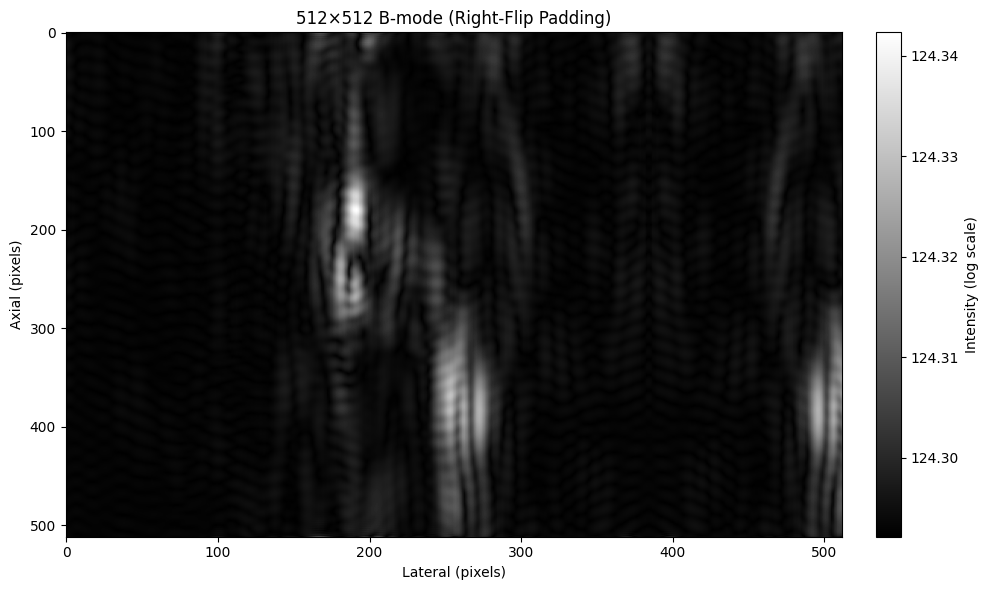

In [48]:
# Crop a 512×W section from depth 2000
rf_section = VivoTK[2000:2000+512, :]   # shape = (512, W)
H, W = rf_section.shape                  # H=512, W=384 (for example)

# Step 1: Copy original into new 512×512 matrix
rf_filled = np.zeros((512, 512), dtype=rf_section.dtype)
rf_filled[:, :W] = rf_section

# Step 2: Fill remaining with flipped rightmost part
fill_width = 512 - W                     # 512 - 384 = 128
rf_filled[:, W:] = np.fliplr(rf_section[:, -fill_width:])

# Step 3: Hilbert transform + log compression
LogB = 500
env = np.abs(hilbert(rf_filled, axis=0))
log_env = 20*np.log(env + LogB)             # result is shape (512, 512)

# --- OPTION A: Simple Plot with Axes and Colorbar ---
plt.figure(figsize=(10, 6))
im = plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('512×512 B-mode (Right-Flip Padding)')
plt.xlabel('Lateral (pixels)')
plt.ylabel('Axial (pixels)')
plt.colorbar(im, fraction=0.046, pad=0.04, label='Intensity (log scale)')
plt.tight_layout()
plt.show()


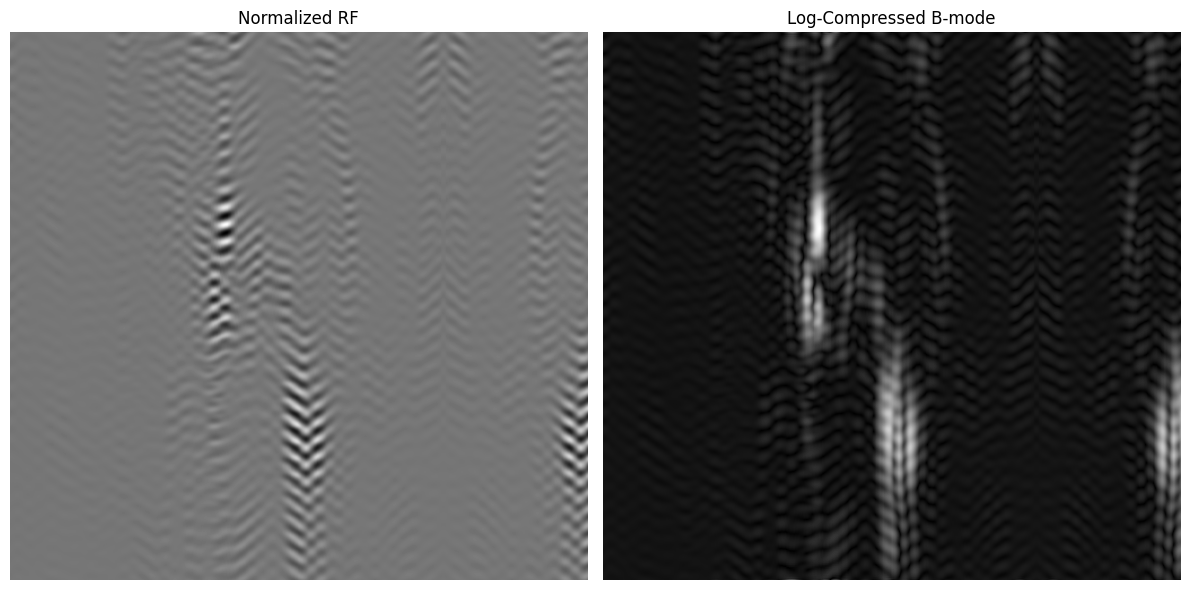

In [51]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# === Load RF data ===
mat = scipy.io.loadmat("exp/datasets/carotidNew/rf_512.mat")
rf = mat['data']  # Should be (512, 512)

# === Compute B-mode from RF ===
env = np.abs(hilbert(rf, axis=0))
logB = 100  # Log compression baseline
bmode = np.log(env + logB)

# === Plot RF and B-mode side by side ===
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(rf, cmap='gray', aspect='auto')
plt.title("Normalized RF")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bmode, cmap='gray', aspect='auto')
plt.title("Log-Compressed B-mode")
plt.axis('off')

plt.tight_layout()
plt.show()


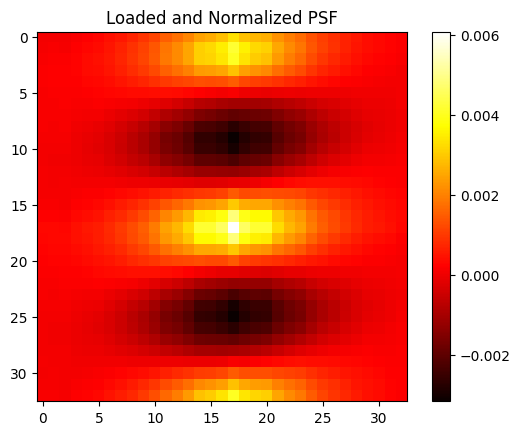

In [53]:
import scipy.io
import numpy as np

psf_data = scipy.io.loadmat('exp/datasets/carotidNew/psf_crop.mat')
kernel = psf_data[psf_keys[0]]
kernel = kernel / (np.sum(np.abs(kernel)) + 1e-8)

# Optionally visualize
import matplotlib.pyplot as plt
plt.imshow(kernel, cmap='hot')
plt.colorbar()
plt.title('Loaded and Normalized PSF')
plt.show()


In [54]:
folder_name = "carotid_New"

In [56]:
!python main.py \
  --ni \
  --config deblur_carotid.yml \
  --doc imagenet_ood \
  --timesteps 20 \
  --eta 0.85 --etaB 1 \
  --deg deblur_bccb --sigma_0 20 \
  -i carotid_New


Module path: /projects/minds/PDAS-M2-2025/DDPM
Current sys.path: ['/projects/minds/PDAS-M2-2025/Stable_DDRM', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/pdas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/projects/minds/PDAS-M2-2025/DDPM']
File not found: /projects/minds/PDAS-M2-2025/DDPM/denoising_diffusion_pytorch.py
Import failed: No module named 'denoising_diffusion_pytorch'
INFO - main.py - 2025-06-05 17:33:50,318 - Using device: cuda
INFO - main.py - 2025-06-05 17:33:50,319 - Writing log file to exp/logs/imagenet_ood
INFO - main.py - 2025-06-05 17:33:50,319 - Exp instance id = 2754006
INFO - main.py - 2025-06-05 17:33:50,319 - Exp comment = 
building dataset from exp/carotidNew.txt
read meta done
Start from 0
  0%|                                                     | 0/1 [0

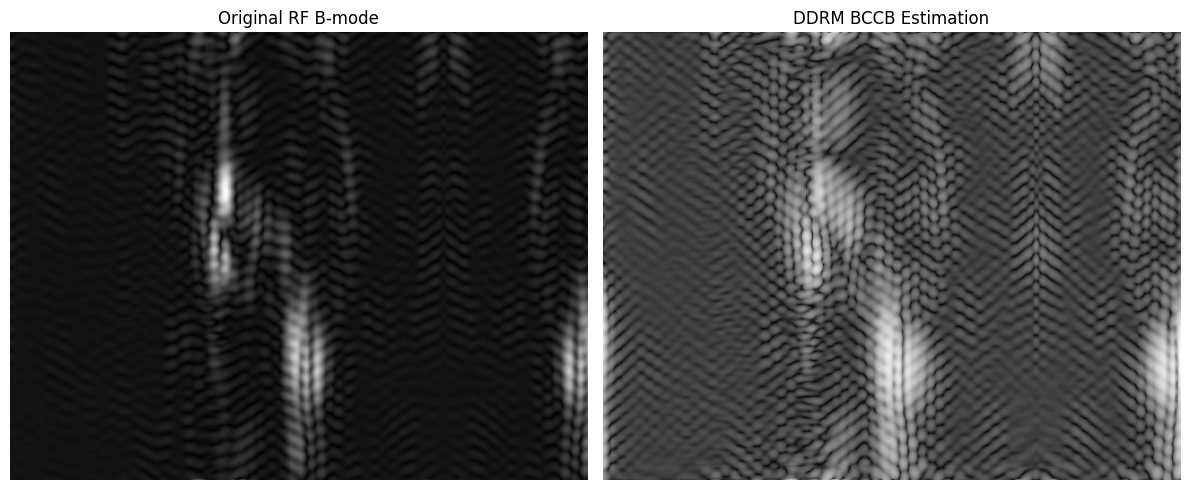

In [57]:
# 1) Load the DDRM output (.mat) and extract 'image'
mat = scipy.io.loadmat('exp/image_samples/carotid_New/0_-1.mat')
image = mat['image']  # shape is (C, H, W)

# 2) Permute from (C, H, W) → (H, W, C):
image = np.transpose(image, (1, 2, 0))

# 3) Convert to grayscale by averaging over channels:
grayimage = np.mean(image, axis=2)  # shape is (H, W)

# 4) Compute the Hilbert envelope along each column (axis=0):
analytic = hilbert(grayimage, axis=0)
envelope = np.abs(analytic)

# 5) Apply log compression with LogB = 1000:
LogB = 100
bmode = np.log(envelope + LogB)

# === Load RF data ===
mat = scipy.io.loadmat("exp/datasets/carotidNew/rf_512.mat")
rf = mat['data']  # Should be (512, 512)

# === Compute B-mode from RF ===
env = np.abs(hilbert(rf, axis=0))
logB = 1000  # Log compression baseline
bmode_vivo = np.log(env + logB)

# Plot side-by-side (both same, for now)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(bmode_vivo, cmap='gray', aspect='auto')
plt.title("Original RF B-mode")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bmode, cmap='gray', aspect='auto')
plt.title("DDRM BCCB Estimation")
plt.axis('off')

plt.tight_layout()
plt.show()